In [17]:
!ls

Data                             tensorflow-apple-metal-conda.yml
README.md                        weather_classification.ipynb
images                           weather_prediction.ipynb


#### Step One: Import all the necessary libraries

In [69]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from keras import Sequential
from tensorflow.keras import layers

from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import classification_report, precision_score, recall_score

#### Step Two: Loading Data.

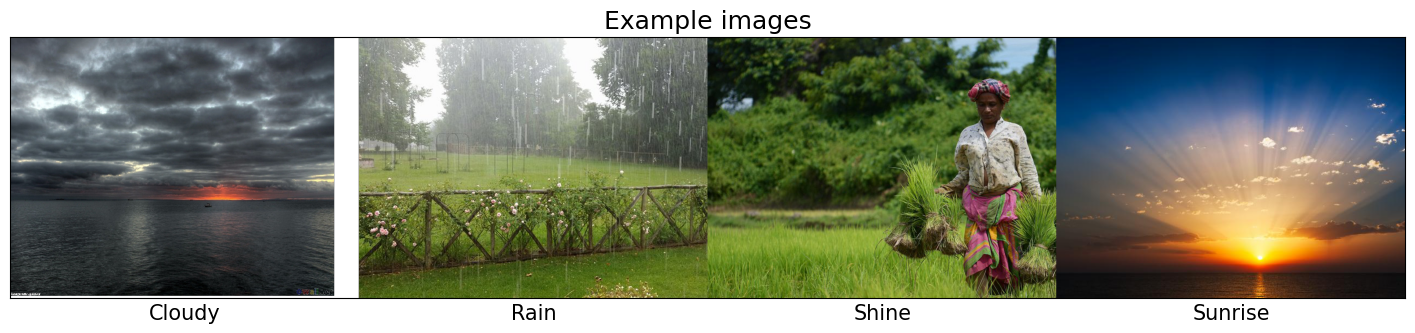

In [67]:
classes = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

cloudy_img = Image.open('images/Cloudy/cloudy136.jpg')
rain_img = Image.open('images/Rain/rain180.jpg')
shine_img = Image.open('images/Shine/shine254.jpeg')
sunrise_img = Image.open('images/Sunrise/sunrise1.jpg')
example_imgs = [cloudy_img, rain_img, shine_img, sunrise_img]

w, h = example_imgs[1].size
grid = Image.new('RGBA', size = (4 * w, h))
grid_w, grid_h = grid.size
ls = grid_w / 4   # label spacing

for i, img in enumerate(example_imgs):
    grid.paste(img, box = (i % 4 * w, i // 4 * h))

plt.figure(figsize = (18,10))
plt.title('Example images', fontsize=18)
plt.imshow(grid)
plt.xticks([ls - ls/2, ls * 2 - ls / 2, ls * 3 - ls / 2, ls * 4 - ls / 2], 
           classes, fontsize = 15)
plt.tick_params(axis = u'both', which = u'both',length = 0)
plt.yticks([])
plt.show()

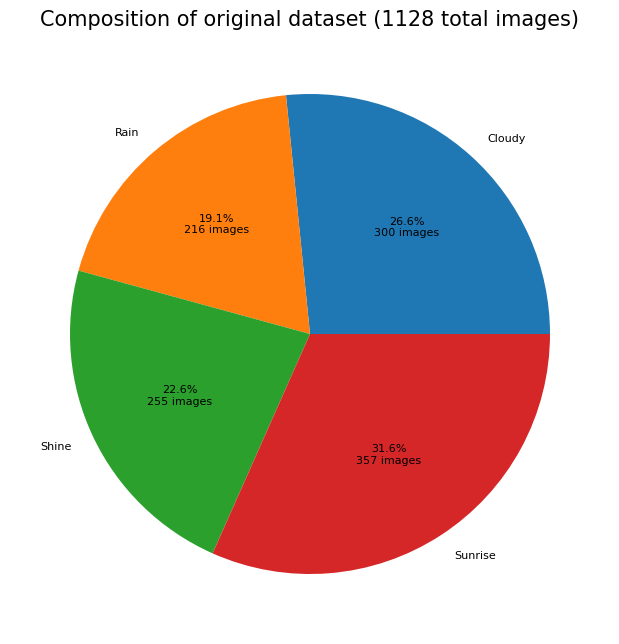

In [27]:
# Image distribution in each folder.
cloudy_images = len(os.listdir('images/Cloudy/'))
rain_images = len(os.listdir('images/Rain/'))
shine_images = len(os.listdir('images/Shine/'))
sunrise_images = len(os.listdir('images/Sunrise/'))

# Plot distribution of image classes
def label_pie(pct, allvals):
    absolute = int(round(pct / 100. * np.sum(allvals)))
    return "{:.1f}%\n{:d} images".format(pct, absolute)

fig = plt.figure(figsize = (6, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('equal')
weather_conditions = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

total_images = [cloudy_images, rain_images, shine_images, sunrise_images]
ax.pie(total_images, labels = weather_conditions, autopct = lambda pct: 
       label_pie(pct, total_images), textprops={'fontsize': 8})

plt.title('Composition of original dataset ({} total images)'.format(sum(total_images)),
          fontsize=15)
plt.show()

- Define the weather condition.
- Create a dictionary that takes some parameters that we will path to a function to read our images.

In [28]:
weather_cond = ('Cloudy', 'Rain', 'Shine', 'Sunrise')

In [31]:
weather_dict = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": weather_cond
}

- Create a function that will load our data (tf.keras.utils.image_dataset_from_directory).
- Then pass our dictionary above and load the data.

In [33]:
train_weather = tf.keras.utils.image_dataset_from_directory(
    "images",
    subset = "training",
    ** weather_dict
)

test_weather = tf.keras.utils.image_dataset_from_directory(
  "images",
  subset = "validation",
    ** weather_dict
)

Found 1126 files belonging to 4 classes.
Using 901 files for training.
Found 1126 files belonging to 4 classes.
Using 225 files for validation.


In [37]:
# Lets check our data types.
test_weather
train_weather

# As showing below... Our data type is a batch dataset class.

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

#### Step Three: Exploritory Data Analysis

- Let's explore our data batch.
    - NOTE: As stated in our dictionary above, a batch size has 32 images.

In [41]:
first_batch = train_weather.take(1)
first_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [42]:
# Lets check the first image in our batch
images, labels = list(first_batch)[0]
first_image = images[0]

In [43]:
first_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[75.94531 , 74.83594 , 74.      ],
       [75.50781 , 74.470215, 73.88037 ],
       [74.82373 , 73.927246, 73.60156 ]], dtype=float32)>

As showing above Tensorflow stored our images as Numpy Array. 

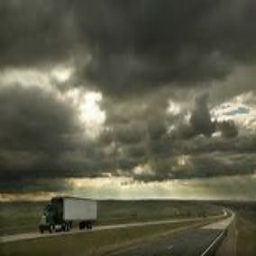

In [53]:
# Lets display our image using PIL image.
Image.fromarray(images[0].numpy().astype("uint8"))

In [59]:
print(labels[0])

tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


In [54]:
second_batch = train_weather.take(2)
second_batch

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [55]:
# Lets check the second image in our second batch.
images, labels = list(second_batch)[1]
second_image = images[1]

In [56]:
second_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[75.94531 , 74.83594 , 74.      ],
       [75.50781 , 74.470215, 73.88037 ],
       [74.82373 , 73.927246, 73.60156 ]], dtype=float32)>

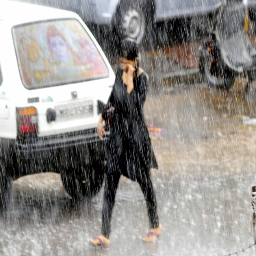

In [58]:
# Lets display our image using PIL image.
Image.fromarray(images[2].numpy().astype("uint8"))

In [60]:
print(labels[2])

tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)


#### Step Four: Preparing Data for Modeling

In [61]:
# Training & Testing Data
X_train = train_weather.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
x_test = test_weather.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

##### First Model

- Create a Sequential model.
    - rescale the data for easy Neural Networks prediction.
    - Create a 2D convolutional layer that scan our images & extract features.
    - Create a flatten layer.
    - create a dense layer to get the prediction.

In [70]:
model = Sequential([
  tf.keras.layers.Rescaling(1. / 255),
  layers.Conv2D(16, 3, padding = 'same', activation='relu', input_shape = (256, 256, 3)),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(len(weather_cond))
])

In [71]:
# Compile the model for prediction
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [79]:
# Fit the model to the training data
base_model = model.fit(
    X_train,
    validation_data = x_test,
    epochs = 5,
    verbose = 1
)

Epoch 1/5
29/29 [==============================] - 19s 646ms/step - loss: 0.0292 - accuracy: 0.9956 - val_loss: 0.5601 - val_accuracy: 0.9067
Epoch 2/5
29/29 [==============================] - 19s 648ms/step - loss: 0.0185 - accuracy: 0.9945 - val_loss: 0.6302 - val_accuracy: 0.9022
Epoch 3/5
29/29 [==============================] - 19s 647ms/step - loss: 0.0201 - accuracy: 0.9956 - val_loss: 0.6713 - val_accuracy: 0.8978
Epoch 4/5
29/29 [==============================] - 19s 647ms/step - loss: 0.0292 - accuracy: 0.9878 - val_loss: 0.7497 - val_accuracy: 0.8844
Epoch 5/5
29/29 [==============================] - 19s 647ms/step - loss: 0.0375 - accuracy: 0.9889 - val_loss: 0.7613 - val_accuracy: 0.8711


In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 134,218,820
Trainable params: 134,218,820
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

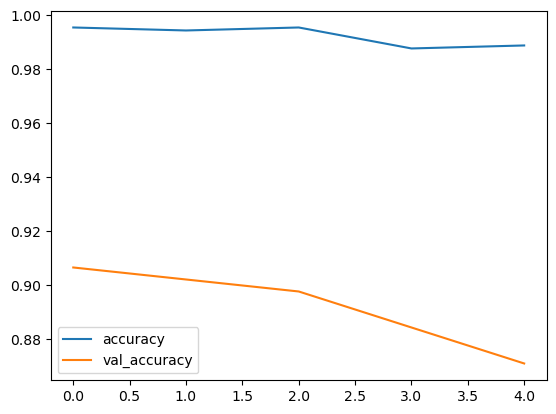

In [81]:
base_model_df = pd.DataFrame.from_dict(base_model.history)
base_model_df[["accuracy", "val_accuracy"]].plot()

According to the results above. Our model indicates that training accuracy is doing really well compared to the validation accuracy. Or in other words this indicates that our model is a little bit overfitting.

#### Second Model